## Neural network for fashion_MNIST data

In [9]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

## Data processing

In [11]:
# Load the data
df_test = pd.read_csv('fashion-mnist_test.csv')
df_train = pd.read_csv('fashion-mnist_train.csv')

df_train = np.array(df_train, dtype = 'int32')
df_test = np.array(df_test, dtype = 'int32')

x_train = df_train[:,1:]

y_train = df_train[:,0]

x_test= df_test[:,1:]

y_test=df_test[:,0]
m_train = x_train.shape[0]
m_test = x_test.shape[0]

In [12]:
# Creating validation data sets
m_train = 59000
m_validation = 1000

mask = list(range(m_train, m_train + m_validation))
x_val = x_train[mask]
y_val = y_train[mask]

mask = list(range(m_train))
x_train = x_train[mask]
y_train = y_train[mask]

mask = list(range(m_test))
x_test = x_test[mask]
y_test = y_test[mask]

# Reshaping data
x_train = x_train.reshape(m_train, -1)
x_val = x_val.reshape(m_validation, -1)
x_test = x_test.reshape(m_test, -1)

## Defining neural network

In [5]:
class TwoLayerNet(object):    

    def __init__(self, input_size, hidden_size, output_size, std=1e-4): 
        """
        Initialize the model. Weights are initialized to small random values and
        biases are initialized to zero. Weights and biases are stored in the
        variable self.params, which is a dictionary with the following keys:

        W1: First layer weights; has shape (D, H)
        b1: First layer biases; has shape (H,)
        W2: Second layer weights; has shape (H, C)
        b2: Second layer biases; has shape (C,)

        Inputs:
        - input_size: The dimension D of the input data.
        - hidden_size: The number of neurons H in the hidden layer.
        - output_size: The number of classes C.
        """
        self.params = {}    
        self.params['W1'] = std * np.random.randn(input_size, hidden_size)   
        self.params['b1'] = np.zeros((1, hidden_size))    
        self.params['W2'] = std * np.random.randn(hidden_size, output_size)   
        self.params['b2'] = np.zeros((1, output_size))

    def loss(self, X, y=None, reg=0.0):
        """
        Compute the loss and gradients for a two layer fully connected neural
        network.

        Inputs:
        - X: Input data of shape (N, D). Each X[i] is a training sample.
        - y: Vector of training labels. y[i] is the label for X[i], and each y[i] is
          an integer in the range 0 <= y[i] < C. This parameter is optional; if it
          is not passed then we only return scores, and if it is passed then we
          instead return the loss and gradients.
        - reg: Regularization strength.

        Returns:
        If y is None, return a matrix scores of shape (N, C) where scores[i, c] is
        the score for class c on input X[i].

        If y is not None, instead return a tuple of:
        - loss: Loss (data loss and regularization loss) for this batch of training
          samples.
        - grads: Dictionary mapping parameter names to gradients of those parameters
          with respect to the loss function; has the same keys as self.params.
        """
        # Unpack variables from the params dictionary
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        N, D = X.shape
        
        # Compute the forward pass
        scores = None
        h1 = ReLU(np.dot(X, W1) + b1)      
        out = np.dot(h1, W2) + b2          
        scores = out
        
        # If the targets are not given then jump out, we're done
        if y is None:   
            return scores
        
        # Compute the loss
        scores_max = np.max(scores, axis=1, keepdims=True)    # (N,1)
        exp_scores = np.exp(scores - scores_max)              # (N,C)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)    # (N,C)
        correct_logprobs = -np.log(probs[range(N), y])        # (N,1)
        data_loss = np.sum(correct_logprobs) / N
        reg_loss = 0.5 * reg * np.sum(W1*W1) + 0.5 * reg * np.sum(W2*W2)
        loss = data_loss + reg_loss
        
        # Backward pass: compute gradients
        grads = {}
        dscores = probs                                 # (N,C)
        dscores[range(N), y] -= 1
        dscores /= N
        dW2 = np.dot(h1.T, dscores)                     # (H,C)
        db2 = np.sum(dscores, axis=0, keepdims=True)    # (1,C)
        dh1 = np.dot(dscores, W2.T)                     # (N,H)
        dh1[h1 <= 0] = 0
        dW1 = np.dot(X.T, dh1)                          # (D,H)
        db1 = np.sum(dh1, axis=0, keepdims=True)        # (1,H)
        dW2 += reg * W2
        dW1 += reg * W1
        
        grads['W1'] = dW1
        grads['b1'] = db1
        grads['W2'] = dW2
        grads['b2'] = db2

        return loss, grads

    def train(self, X, y, X_val, y_val, learning_rate=1e-3, 
               learning_rate_decay=0.95, reg=1e-5, mu=0.9, num_epochs=10, 
               mu_increase=1.0, batch_size=200, verbose=False):   
        """
        Train this neural network using stochastic gradient descent.

        Inputs:
        - X: A numpy array of shape (N, D) giving training data.
        - y: A numpy array f shape (N,) giving training labels; y[i] = c means that
          X[i] has label c, where 0 <= c < C.
        - X_val: A numpy array of shape (N_val, D) giving validation data.
        - y_val: A numpy array of shape (N_val,) giving validation labels.
        - learning_rate: Scalar giving learning rate for optimization.
        - learning_rate_decay: Scalar giving factor used to decay the learning rate
          after each epoch.
        - reg: Scalar giving regularization strength.
        - num_iters: Number of steps to take when optimizing.
        - batch_size: Number of training examples to use per step.
        - verbose: boolean; if true print progress during optimization.
        """
        num_train = X.shape[0]
        iterations_per_epoch = max(int(num_train / batch_size), 1)
        
        # Use SGD to optimize the parameters in self.model
        v_W2, v_b2 = 0.0, 0.0
        v_W1, v_b1 = 0.0, 0.0
        loss_history = []
        train_acc_history = []
        val_acc_history = []

        for it in range(1, num_epochs * iterations_per_epoch + 1):   
            X_batch = None   
            y_batch = None 
            
            # Create a random minibatch of training data and labels
            sample_index = np.random.choice(num_train, batch_size, replace=True)   
            X_batch = X[sample_index, :]          
            y_batch = y[sample_index]             
            
            # Compute loss and gradients using the current minibatch
            loss, grads = self.loss(X_batch, y=y_batch, reg=reg) 
            loss_history.append(loss)
            
            # Use the gradients to update the parameters of the network
            v_W2 = mu * v_W2 - learning_rate * grads['W2']    
            self.params['W2'] += v_W2   
            v_b2 = mu * v_b2 - learning_rate * grads['b2']    
            self.params['b2'] += v_b2   
            v_W1 = mu * v_W1 - learning_rate * grads['W1']    
            self.params['W1'] += v_W1   
            v_b1 = mu * v_b1 - learning_rate * grads['b1']  
            self.params['b1'] += v_b1
            
            if verbose and it % iterations_per_epoch == 0:    
            # Every epoch, check train and val accuracy and decay learning rate.
                epoch = it / iterations_per_epoch    
                train_acc = (self.predict(X_batch) == y_batch).mean()    
                val_acc = (self.predict(X_val) == y_val).mean()    
                train_acc_history.append(train_acc)    
                val_acc_history.append(val_acc)    
                print("epoch %d / %d: loss %f, train_acc: %f, val_acc: %f" % 
                                    (epoch, num_epochs, loss, train_acc, val_acc))
                
                # Decay learning rate
                learning_rate *= learning_rate_decay    
                mu *= mu_increase

        return {   
            'loss_history': loss_history,   
            'train_acc_history': train_acc_history,   
            'val_acc_history': val_acc_history,
        }

    def predict(self, X):    
        """
        Use the trained weights of this two-layer network to predict labels for
        data points. For each data point we predict scores for each of the C
        classes, and assign each data point to the class with the highest score.

        Inputs:
        - X: A numpy array of shape (N, D) giving N D-dimensional data points to
          classify.

        Returns:
        - y_pred: A numpy array of shape (N,) giving predicted labels for each of
        the elements of X. For all i, y_pred[i] = c means that X[i] is predicted
        to have class c, where 0 <= c < C.
        """
        y_pred = None    
        h1 = ReLU(np.dot(X, self.params['W1']) + self.params['b1'])    
        scores = np.dot(h1, self.params['W2']) + self.params['b2']    
        y_pred = np.argmax(scores, axis=1)    

        return y_pred

def ReLU(x):    
     
    return np.maximum(0, x)

## Training and Analysis

In [6]:
input_size = x_train.shape[1]
score=[]
for hidden_size in [2,3,4,5,10,15,20,30,50,100]:
    num_classes = 10
    net = TwoLayerNet(input_size, hidden_size, num_classes)

    # Train the network
    stats = net.train(x_train, y_train, x_val, y_val,
                num_epochs=10, batch_size=1024,
                learning_rate=7.5e-4, learning_rate_decay=0.95,
                reg=1.0, verbose=False)

    # Predict on the validation set
    val_acc = (net.predict(x_val) == y_val).mean()
    score.append(val_acc)

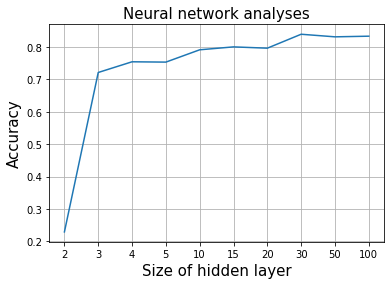

In [7]:
plt.plot(score)
plt.title("Neural network analyses", fontsize=15)
plt.xlabel('Size of hidden layer',fontsize=15)
plt.ylabel('Accuracy',fontsize=15)
positions = (0,1,2,3,4,5,6,7,8,9)
labels = ('2','3','4','5','10','15','20','30','50','100')
plt.xticks(positions, labels)
plt.grid(b=None, which='major', axis='both')

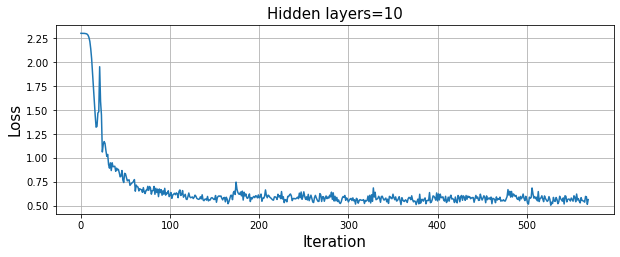

In [8]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.subplots_adjust(wspace =0, hspace =0.3)


# Plot the loss function and train / validation accuracies

plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Hidden layers=10', fontsize=15)
plt.xlabel('Iteration', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.grid(b=None, which='major', axis='both')
